In [1]:
"""
This is a single agent actor-critic implementation.
It is specifically designed to work with the four rooms environment, but it should work with any gym environment.
"""

import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
class ActorCriticSingleAgent(nn.Module):
    """
    A simple, but flexible, implementation of the actor-critic algorithm.
    """
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCriticSingleAgent, self).__init__()

        self.num_actions = num_actions
        # estimate the value function
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        # estimate the policy distribution
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        """
        Do inference to calculate the action probabilities and the state value.
        """
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        # softmax effectively generates a probability for each of our output options
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [28]:
"""
This doesn't quite use entropy correctly and it doesn't bootstrap correctly.
BUT. it is a start.
"""
def a2c(env, hidden_size, learning_rate, num_episodes, num_steps, gamma=0.99):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    actor_critic = ActorCriticSingleAgent(num_inputs, num_outputs, hidden_size)
    # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    # all episode length
    all_lengths = []
    # average episode length
    average_lengths = []
    # all episode rewards
    all_rewards = []
    
    entropy_term = 0

    for episode in range(num_episodes):
        log_probs = []
        values = []
        rewards = []

        state, _ = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            # drop the tensor dimension and computational graph info
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            # Sample an action according the probs the network just output.
            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            # Calculate the log probability of the action we've taken
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            # 
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:
                    # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        # These are the rewards plus discounted state values to calculate the advantage
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + gamma * Qval
            Qvals[t] = Qval
  
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

    return all_rewards, all_lengths, average_lengths

In [17]:

env = gym.make("CartPole-v0")
hidden_size = 256
learning_rate = 3e-4

# Constants
gamma = 0.99
num_steps = 300
max_episodes = 3000
all_rewards, all_lengths, average_lengths = a2c(env, hidden_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

/home/douglas/classes/RL/project/CS5180-project/venv/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


episode: 0, reward: 12.0, total length: 11, average length: 11.0 
episode: 10, reward: 13.0, total length: 12, average length: 18.2 
episode: 20, reward: 40.0, total length: 39, average length: 26.5 
episode: 30, reward: 20.0, total length: 19, average length: 21.6 
episode: 40, reward: 19.0, total length: 18, average length: 25.5 
episode: 50, reward: 26.0, total length: 25, average length: 16.2 
episode: 60, reward: 9.0, total length: 8, average length: 28.8 
episode: 70, reward: 23.0, total length: 22, average length: 26.0 
episode: 80, reward: 30.0, total length: 29, average length: 20.2 
episode: 90, reward: 65.0, total length: 64, average length: 33.0 
episode: 100, reward: 25.0, total length: 24, average length: 27.1 
episode: 110, reward: 46.0, total length: 45, average length: 25.3 
episode: 120, reward: 42.0, total length: 41, average length: 29.7 
episode: 130, reward: 22.0, total length: 21, average length: 27.6 
episode: 140, reward: 31.0, total length: 30, average length:

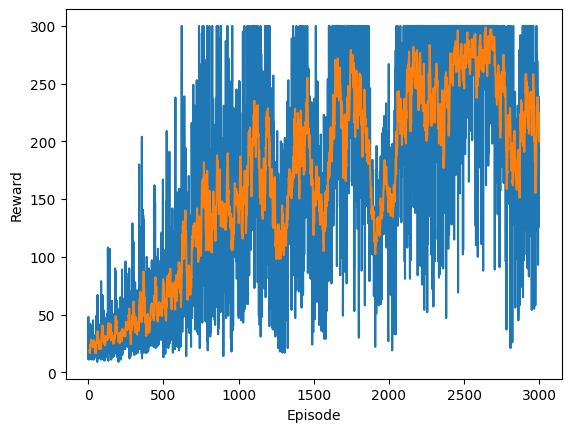

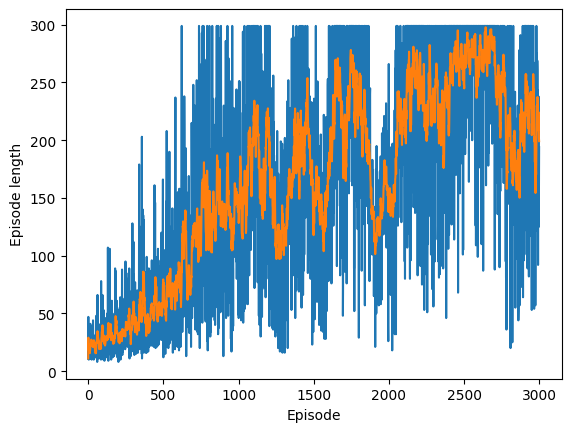

In [18]:
# Plot results for cartpole
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(all_lengths)
plt.plot(average_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode length')
plt.show()

In [45]:
"""
An OpenAI Gym environment for the Four Rooms domain. 
This is modified with permission from Christian Diamore's work.
"""

import gym
import numpy as np
from gym import spaces
from gym.utils import seeding

rooms = [
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
]


class FourRooms(gym.Env):
    def __init__(self, grid: list = rooms, timeout=459):
        # define the four room as a 2-D array for easy state space reference and
        # visualization 0 represents an empty cell; 1 represents a wall cell

        # NOTE: the origin for a 2-D numpy array is located at top-left
        # while the origin for the FourRooms is at the bottom-left. The following
        # codes performs the re-projection by reversing the rows
        self.grid = np.array(list(reversed(grid)))

        # define the action space
        self.observation_space, self.action_space = (
            spaces.MultiDiscrete(self.grid.shape, dtype=np.int8),
            spaces.Box(low=-1, high=1, shape=(2,), dtype=int),
        )

        # define the start and goal state
        self.agent_state = (0, 0)
        self.start_state = (0, 0)
        self.goal_state = (10, 10)

        self.t = 0
        self.timeout = timeout

    def reset(self):
        """
        Reset the agent's state to the start state [0, 0]
        Return both the start state and reward
        """
        # reset the agent state to be [0, 0]
        self.agent_state, self.t = self.start_state, 0
        return np.array(self.agent_state), {}

    def is_wall(self, state: tuple):
        return (
            not self.observation_space.contains(np.array(state))
            or self.grid[state] == 1
        )

    def step(self, act: tuple):
        """
        :param act:
            a tuple in {[1, 0], [-1, 0], [0, 1], [0, -1]} representing an
            update to the state space

        :returns:
            :next_state: tuple
                x, y integer coordinates of the agent's new state, i.e. (1, 1)
            :reward: int
                1 if the agent reached the goal, else 0
            :done: bool.
                whether the episode is done, either by hitting goal or timeout
                on the episode
        """
        self.t += 1

        # Compute the next state, and only update if we don't hit a wall
        next_state = tuple(np.array(self.agent_state) + np.array(act))
        if not self.is_wall(next_state): self.agent_state = next_state

        # Reward the agent if it hits the goal
        # Done if it was rewarded, or if it times out the episode
        reward = 1.0 if self.agent_state == (10, 10) else -0.5
        done = reward == 1.0 or (self.t >= self.timeout)

        return np.array(self.agent_state), reward, done, False, {}

    def render(self, mode="human"):
        pass


class FourRoomsController(gym.ActionWrapper):
    """Map from a discrete action space into an actual movement in the grid."""

    def __init__(self, environment: gym.Env, controls: dict[int, tuple]):
        assert all(
            environment.action_space.contains(move)
            for move in controls.values()
        )

        super().__init__(environment)
        self.controls = controls
        self.action_space = spaces.Discrete(len(controls))

    def action(self, action):
        return self.controls[action]

    def reverse_action(self, action):
        return -1 * self.controls[action]


class FourRoomsRandomJitter(gym.ActionWrapper):
    """
    With probability p, the agent takes the correct direction.
    With probability 1 - p, the agent takes one of the two perpendicular actions.

    For example, if the correct action is "LEFT", then
        - With probability 0.8, the agent takes action "LEFT";
        - With probability 0.1, the agent takes action "UP";
        - With probability 0.1, the agent takes action "DOWN".
    """
    def __init__(self, environment: gym.Env, p: float = 0.8):
        super().__init__(environment)
        self.p = p

    @staticmethod
    def perpendicular_action(action):
        return np.random.choice([2, 3] if action in [0, 1] else [0, 1], 1)[0]

    def action(self, action):
        return (
            action
            if np.random.uniform() < self.p else
            self.perpendicular_action(action)
        )

    def reverse_action(self, action):
        pass

controls={
    0: (-1, 0),  # 'LEFT'
    1: (1, 0),  # 'RIGHT'
    2: (0, -1),  # 'DOWN'
    3: (0, 1),  # 'UP'
}

timeout = 10_000
four_rooms_env_no_jitter = FourRoomsController(FourRooms(rooms, timeout=timeout), controls=controls)

four_rooms_env_jitter = FourRoomsRandomJitter(
    FourRoomsController(FourRooms(rooms, timeout=timeout), controls=controls), p=0.8
)


/home/douglas/classes/RL/project/CS5180-project/venv/lib/python3.10/site-packages/gym/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [41]:
hidden_size = 64
learning_rate = 3e-4

# Constants
gamma = 0.99
num_steps = timeout
max_episodes = 1000
all_rewards, all_lengths, average_lengths = a2c(four_rooms_env_no_jitter, hidden_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

episode: 0, reward: 0.0, total length: 9999, average length: 9999.0 


KeyboardInterrupt: 

In [42]:
all_rewards, all_lengths, average_lengths = a2c(four_rooms_env_jitter, hidden_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

episode: 0, reward: 1.0, total length: 325, average length: 325.0 
episode: 10, reward: 1.0, total length: 1178, average length: 1922.7 
episode: 20, reward: 1.0, total length: 4543, average length: 1215.7 
episode: 30, reward: 1.0, total length: 7002, average length: 2858.1 
episode: 40, reward: 0.0, total length: 9999, average length: 4441.9 
episode: 50, reward: 1.0, total length: 1032, average length: 3704.0 
episode: 60, reward: 1.0, total length: 1553, average length: 3333.7 
episode: 70, reward: 1.0, total length: 9697, average length: 2809.3 
episode: 80, reward: 1.0, total length: 5438, average length: 3785.8 
episode: 90, reward: 1.0, total length: 3807, average length: 3929.7 
episode: 100, reward: 1.0, total length: 5956, average length: 5331.5 
episode: 110, reward: 0.0, total length: 9999, average length: 8043.8 
episode: 120, reward: 1.0, total length: 6024, average length: 6295.5 
episode: 130, reward: 1.0, total length: 2726, average length: 4651.3 
episode: 140, rewar

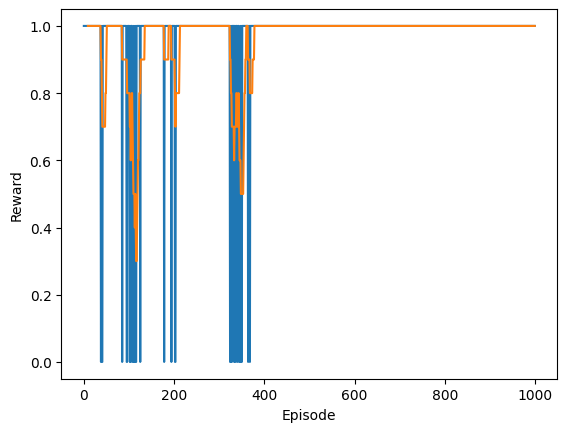

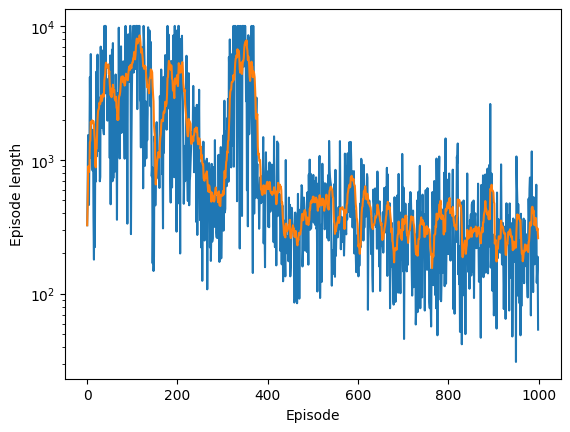

In [44]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(all_lengths)
plt.plot(average_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode length')
# modify the y axis to be on a log scale
plt.yscale('log')
plt.show()
"""
THESE RESULTS WERE WITH A2C reward of 1 on episode completion only
"""

In [46]:
"""
These results are generated with a2c reward of 1 on episode completion and -0.5 on every step
"""

all_rewards, all_lengths, average_lengths = a2c(four_rooms_env_jitter, hidden_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

episode: 0, reward: -228.0, total length: 458, average length: 458.0 
episode: 10, reward: -148.5, total length: 299, average length: 249.9 
episode: 20, reward: -152.0, total length: 306, average length: 246.2 
episode: 30, reward: -74.0, total length: 150, average length: 201.5 
episode: 40, reward: -128.0, total length: 258, average length: 318.5 
episode: 50, reward: -60.0, total length: 122, average length: 288.4 
episode: 60, reward: -82.5, total length: 167, average length: 325.2 
episode: 70, reward: -72.5, total length: 147, average length: 363.9 
episode: 80, reward: -240.5, total length: 483, average length: 662.9 
episode: 90, reward: -44.5, total length: 91, average length: 238.1 
episode: 100, reward: -115.0, total length: 232, average length: 229.2 
episode: 110, reward: -90.5, total length: 183, average length: 202.8 
episode: 120, reward: -193.0, total length: 388, average length: 309.2 
episode: 130, reward: -28.5, total length: 59, average length: 190.4 
episode: 140

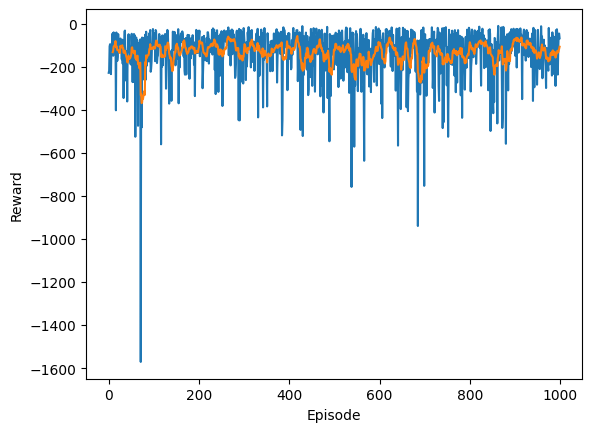

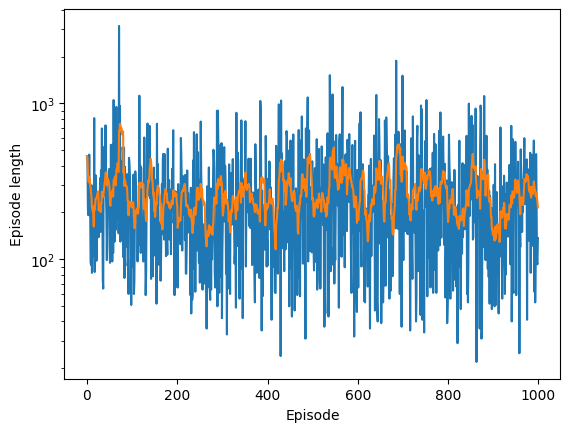

In [47]:
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(all_lengths)
plt.plot(average_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode length')
# modify the y axis to be on a log scale
plt.yscale('log')
plt.show()